In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

[nltk_data] Downloading package vader_lexicon to C:\Users\AARON-
[nltk_data]     PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    print(url)
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

https://finviz.com/quote.ashx?t=AMZN
https://finviz.com/quote.ashx?t=TSLA
https://finviz.com/quote.ashx?t=GOOG


In [3]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

The "Amazon" of Japan, Rakuten, Selling $2.2 Billion in New Stock
Mar-12-21 08:41PM  
Amazon Ordered to Close Canadian Facility on Covid-19 Cases
06:25PM  
UPDATE 1-Amazon Canada asked to shut Brampton facility on COVID-19 concerns
06:22PM  
Coupang Is the Amazon.com of South Korea, but Maybe Even Better. And Now You Can Buy the Stock.
06:02PM  


In [4]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN',
  'Mar-12-21',
  '08:41PM',
  'The "Amazon" of Japan, Rakuten, Selling $2.2 Billion in New Stock'],
 ['AMZN',
  'Mar-12-21',
  '06:25PM',
  'Amazon Ordered to Close Canadian Facility on Covid-19 Cases'],
 ['AMZN',
  'Mar-12-21',
  '06:22PM',
  'UPDATE 1-Amazon Canada asked to shut Brampton facility on COVID-19 concerns'],
 ['AMZN',
  'Mar-12-21',
  '06:02PM',
  'Coupang Is the Amazon.com of South Korea, but Maybe Even Better. And Now You Can Buy the Stock.'],
 ['AMZN',
  'Mar-12-21',
  '03:21PM',
  'Rakuten Divests 8% Stake To Japan Post, Tencent, Walmart To Intensify Battle Against Amazon: Report'],
 ['AMZN',
  'Mar-12-21',
  '02:23PM',
  'Three stocks to benefit from the latest round of stimulus checks'],
 ['AMZN',
  'Mar-12-21',
  '01:56PM',
  'UPDATE 2-Rubio first U.S. Republican senator to support union push at Amazon.com'],
 ['AMZN',
  'Mar-12-21',
  '01:34PM',
  'Bernie Sanders Invites Jeff Bezos to Hearing on Income Inequality'],
 ['AMZN',
  'Mar-12-21',
  '01:04PM',


In [5]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2021-03-12,08:41PM,"The ""Amazon"" of Japan, Rakuten, Selling $2.2 B...",0.00,1.000,0.000,0.0000
1,AMZN,2021-03-12,06:25PM,Amazon Ordered to Close Canadian Facility on C...,0.00,0.825,0.175,0.1779
2,AMZN,2021-03-12,06:22PM,UPDATE 1-Amazon Canada asked to shut Brampton ...,0.00,1.000,0.000,0.0000
3,AMZN,2021-03-12,06:02PM,"Coupang Is the Amazon.com of South Korea, but ...",0.00,0.815,0.185,0.5927
4,AMZN,2021-03-12,03:21PM,"Rakuten Divests 8% Stake To Japan Post, Tencen...",0.15,0.751,0.098,-0.2263


In [6]:
parsed_and_scored_news

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2021-03-12,08:41PM,"The ""Amazon"" of Japan, Rakuten, Selling $2.2 B...",0.000,1.000,0.000,0.0000
1,AMZN,2021-03-12,06:25PM,Amazon Ordered to Close Canadian Facility on C...,0.000,0.825,0.175,0.1779
2,AMZN,2021-03-12,06:22PM,UPDATE 1-Amazon Canada asked to shut Brampton ...,0.000,1.000,0.000,0.0000
3,AMZN,2021-03-12,06:02PM,"Coupang Is the Amazon.com of South Korea, but ...",0.000,0.815,0.185,0.5927
4,AMZN,2021-03-12,03:21PM,"Rakuten Divests 8% Stake To Japan Post, Tencen...",0.150,0.751,0.098,-0.2263
...,...,...,...,...,...,...,...,...
295,GOOG,2021-03-05,04:30PM,Stock Market Today: Tech Roller Coaster Leaves...,0.000,0.734,0.266,0.4404
296,GOOG,2021-03-05,04:17PM,A Comprehensive Guide to Cloud Computing ETFs,0.000,0.714,0.286,0.2500
297,GOOG,2021-03-05,03:40PM,Apple to Face Antitrust Charges Over Spotify C...,0.199,0.741,0.060,-0.4588
298,GOOG,2021-03-05,02:36PM,Biden Sets Stage for Tech Crackdown With White...,0.000,1.000,0.000,0.0000


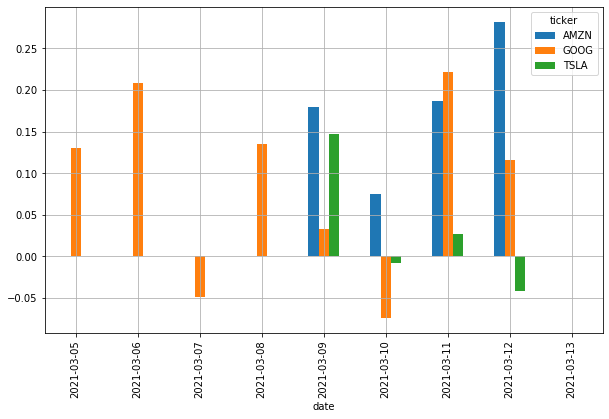

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()